In [1]:
import os
import numpy as np
import pandas as pd
import kagglehub
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    roc_curve, auc, f1_score, accuracy_score, precision_score,
    recall_score, confusion_matrix, mean_squared_error, mean_absolute_error
)
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt

c:\Users\Mikolaj\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Load & cache Adult dataset
def load_adult_dataset(cache_dir="data/", filename="adult.csv"):
    os.makedirs(cache_dir, exist_ok=True)
    csv_path = os.path.join(cache_dir, filename)
    if not os.path.isfile(csv_path):
        ds_path = kagglehub.dataset_download("wenruliu/adult-income-dataset")
        src = os.path.join(ds_path, filename)
        if not os.path.isfile(src):
            raise FileNotFoundError(f"Unable to find {filename} in downloaded dataset")
        os.replace(src, csv_path)
    return pd.read_csv(csv_path).dropna().reset_index(drop=True)

In [3]:
# 2. Encode sensitive attribute and features
def prepare_features(df):
    cols = [c.lower() for c in df.columns]
    key = 'sex' if 'sex' in cols else 'gender'
    s_col = df.columns[cols.index(key)]
    mapping = {'Male':1,'male':1,'Female':0,'female':0}
    df['protected'] = df[s_col].map(mapping)
    df = df.drop(columns=[s_col])
    income_col = 'income_>50K' if 'income_>50K' in df.columns else 'income'
    y = df[income_col].apply(lambda v: 1 if str(v).endswith('>50K') or str(v).endswith('>50k') else 0)
    X = pd.get_dummies(df.drop(columns=[income_col, 'protected']), drop_first=True)
    return X, y, df['protected']

In [4]:
# 3. Cross-validation & hyperparameter tuning
def cross_validate_models(X, y, protected, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    models = {
        'LR': LogisticRegression(solver='liblinear'),
        'RF': RandomForestClassifier(random_state=42)
    }
    params = {
        'LR': {'C': [0.01, 0.1, 1, 10]},
        'RF': {'n_estimators': [50, 100], 'max_depth': [None, 10, 20]}
    }
    results = []
    for name, model in models.items():
        grid = GridSearchCV(model, params[name], cv=skf, scoring='roc_auc')
        grid.fit(X, y)
        best = grid.best_estimator_
        aucs, dp_diffs, eo_diffs, f1s = [], [], [], []
        for train_idx, test_idx in skf.split(X, y):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
            p_tr, p_te = protected.iloc[train_idx], protected.iloc[test_idx]
            best.fit(X_tr, y_tr)
            y_pred = best.predict(X_te)
            y_proba = best.predict_proba(X_te)[:, 1]
            fpr, tpr, _ = roc_curve(y_te, y_proba)
            aucs.append(auc(fpr, tpr))
            dp_diff = y_pred[p_te == 1].mean() - y_pred[p_te == 0].mean()
            tp1 = ((y_te[p_te == 1] == 1) & (y_pred[p_te == 1] == 1)).sum()
            fn1 = ((y_te[p_te == 1] == 1) & (y_pred[p_te == 1] == 0)).sum()
            tp0 = ((y_te[p_te == 0] == 1) & (y_pred[p_te == 0] == 1)).sum()
            fn0 = ((y_te[p_te == 0] == 1) & (y_pred[p_te == 0] == 0)).sum()
            eo_diffs.append(abs(tp1 / (tp1 + fn1) - tp0 / (tp0 + fn0)))
            f1s.append(f1_score(y_te, y_pred, average='macro'))
        results.append({
            'model': name,
            'best_params': grid.best_params_,
            'auc_mean': np.mean(aucs), 'auc_std': np.std(aucs),
            'dp_mean': np.mean(dp_diffs), 'dp_std': np.std(dp_diffs),
            'eo_mean': np.mean(eo_diffs), 'eo_std': np.std(eo_diffs),
            'f1_mean': np.mean(f1s), 'f1_std': np.std(f1s)
        })
    return pd.DataFrame(results)

c:\Users\Mikolaj\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include th

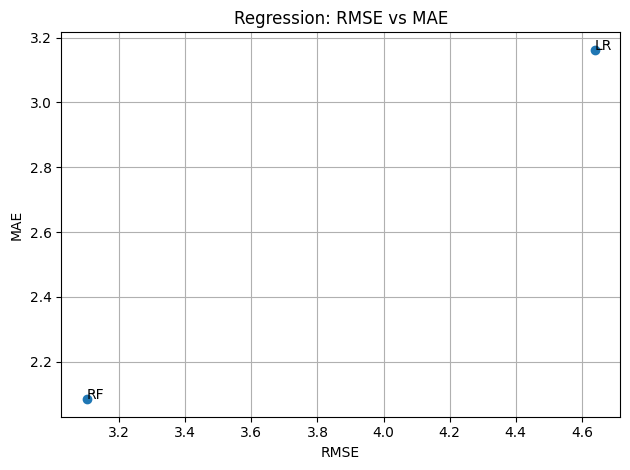

In [5]:
if __name__ == '__main__':
    # Load and preprocess adult dataset
    df = load_adult_dataset()
    X, y, protected = prepare_features(df)

    # --- Regression evaluation (Boston) ---
    boston = load_boston()
    X_reg = pd.DataFrame(boston.data, columns=boston.feature_names)
    y_reg = pd.Series(boston.target, name='PRICE')
    X_tr_reg, X_te_reg, y_tr_reg, y_te_reg = train_test_split(
        X_reg, y_reg, test_size=0.3, random_state=42
    )
    lr_reg = LinearRegression()
    rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
    lr_reg.fit(X_tr_reg, y_tr_reg)
    rf_reg.fit(X_tr_reg, y_tr_reg)
    preds_lr = lr_reg.predict(X_te_reg)
    preds_rf = rf_reg.predict(X_te_reg)
    rmses = [mean_squared_error(y_te_reg, preds_lr, squared=False),
             mean_squared_error(y_te_reg, preds_rf, squared=False)]
    maes  = [mean_absolute_error(y_te_reg, preds_lr),
             mean_absolute_error(y_te_reg, preds_rf)]
    plt.figure()
    plt.scatter(rmses, maes)
    for i,name in enumerate(['LR','RF']):
        plt.annotate(name, (rmses[i], maes[i]))
    plt.xlabel('RMSE')
    plt.ylabel('MAE')
    plt.title('Regression: RMSE vs MAE')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('rmse_mae.png')

c:\Users\Mikolaj\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Mikolaj\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Mikolaj\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Mikolaj\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\Mikolaj\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret =

Cross-validation summary:
   model                             best_params  auc_mean   auc_std  dp_mean  \
0    LR                                {'C': 1}  0.581332  0.007616      NaN   
1    RF  {'max_depth': 20, 'n_estimators': 100}  0.917185  0.002150      NaN   

   dp_std   eo_mean    eo_std   f1_mean    f1_std  
0     NaN  0.031836  0.014662  0.629566  0.005547  
1     NaN  0.090685  0.024131  0.793694  0.004018  
All evaluations complete, plots saved.


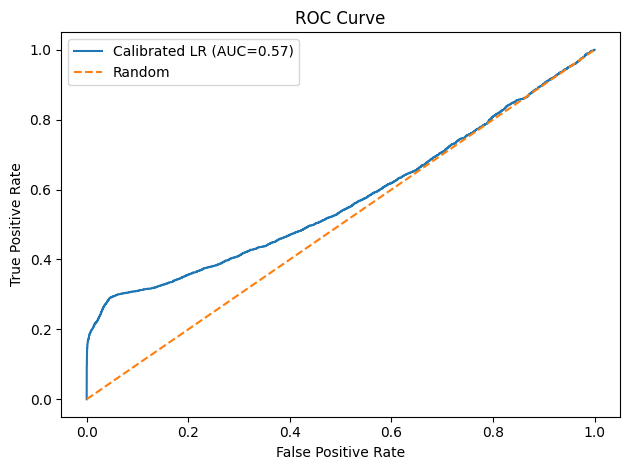

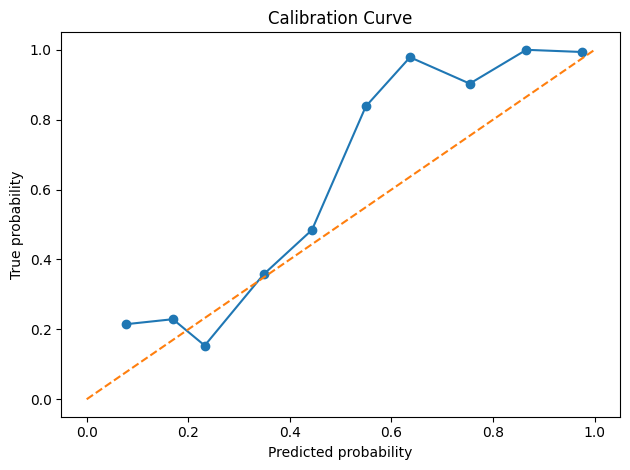

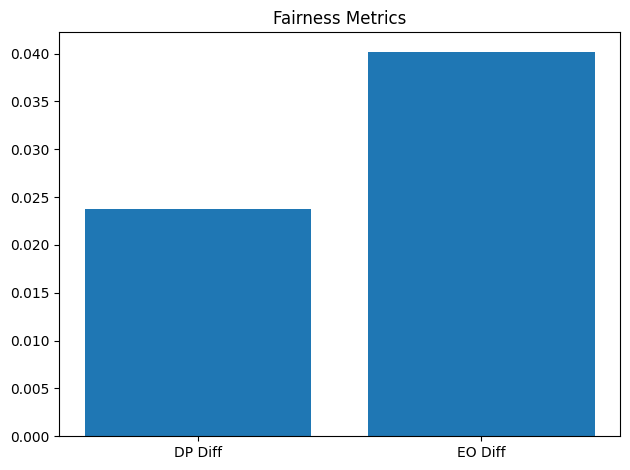

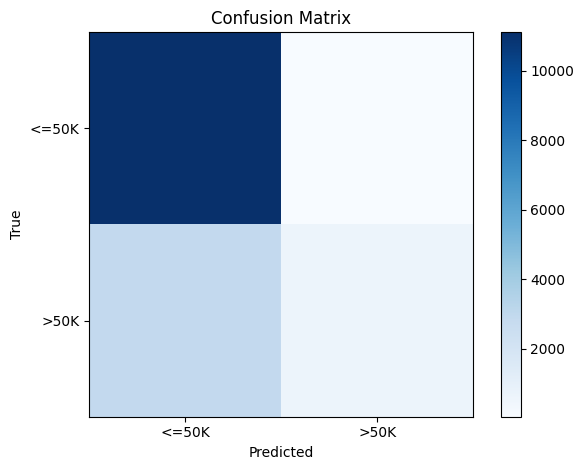

In [8]:
# --- Classification CV and tuning ---
cv_summary = cross_validate_models(X, y, protected, cv=5)
cv_summary.to_csv('cv_summary.csv', index=False)
print("Cross-validation summary:\n", cv_summary)

# --- Final classification calibration ---
X_tr, X_te, y_tr, y_te, p_tr, p_te = train_test_split(
    X, y, protected, stratify=y, test_size=0.3, random_state=42
)
best_C = cv_summary.loc[cv_summary['model'] == 'LR', 'best_params'].iloc[0]['C']
base_lr = LogisticRegression(C=best_C, solver='liblinear')
base_lr.fit(X_tr, y_tr)
calib = CalibratedClassifierCV(base_lr, cv='prefit', method='sigmoid')
calib.fit(X_te, y_te)
y_pred = calib.predict(X_te)
y_proba = calib.predict_proba(X_te)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_te, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"Calibrated LR (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.savefig('roc_final.png')

# Calibration curve
prob_true, prob_pred = calibration_curve(y_te, y_proba, n_bins=10)
plt.figure()
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curve')
plt.tight_layout()
plt.savefig('calibration_final.png')

# Fairness metrics
dp_diff = y_pred[p_te == 1].mean() - y_pred[p_te == 0].mean()
tp1 = ((y_te[p_te==1]==1)&(y_pred[p_te==1]==1)).sum()
fn1 = ((y_te[p_te==1]==1)&(y_pred[p_te==1]==0)).sum()
tp0 = ((y_te[p_te==0]==1)&(y_pred[p_te==0]==1)).sum()
fn0 = ((y_te[p_te==0]==1)&(y_pred[p_te==0]==0)).sum()
eo_diff = abs(tp1/(tp1+fn1) - tp0/(tp0+fn0))
plt.figure()
plt.bar(['DP Diff','EO Diff'], [dp_diff, eo_diff])
plt.title('Fairness Metrics')
plt.tight_layout()
plt.savefig('fairness_final.png')

# Confusion Matrix
cm = confusion_matrix(y_te, y_pred)
plt.figure()
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xticks([0,1], ['<=50K','>50K'])
plt.yticks([0,1], ['<=50K','>50K'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_final.png')

print("All evaluations complete, plots saved.")